# Getting started with PyMC5: Bayesian neural networks

In [33]:
import logging
import pymc as pm
import numpy as np
import arviz as az

import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

print(pm.__version__)

5.6.1


## Introduction to PyMC4

PyMC4 uses [Tensorflow Probability](https://www.tensorflow.org/probability) (TFP) as backend and PyMC4 random variables are wrappers around TFP distributions. Models must be defined as [generator](https://docs.python.org/3/glossary.html#term-generator) functions, using a `yield` keyword for each random variable. PyMC4 uses [coroutines](https://www.python.org/dev/peps/pep-0342/) to interact with the generator to get access to these variables. Depending on the context, PyMC4 may sample values from random variables, compute log probabilities of observed values, ... and so on. Details are covered in the [PyMC4 design guide](https://github.com/pymc-devs/pymc4/blob/master/notebooks/pymc4_design_guide.ipynb). Model generator functions must be decorated with ` @pm.model` as shown in the following trivial example:

In [2]:
# @pm.model
# def model(x):
#     # prior for the mean of a normal distribution
#     loc = yield pm.Normal('loc', loc=0, scale=10)
    
#     # likelihood of observed data
#     obs = yield pm.Normal('obs', loc=loc, scale=1, observed=x)

def Model(x):
    with pm.Model() as model:
        # prior for the mean of a normal distribution
        loc = pm.Normal('loc', mu=0, sigma=10)
        # likelihood of observed data
        obs = pm.Normal('obs', mu=loc, sigma=1, observed=x)
    return model

This models normally distributed data centered at a location `loc` to be inferred. Inference can be started with `pm.sample()` which uses the [No-U-Turn Sampler](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) (NUTS). Samplers other than NUTS are currently not implemented in PyMC4.

In [3]:
# 30 data points normally distributed around 3
x = np.random.randn(30) + 3

# Inference
model = Model(x)
with model:
    trace = pm.sample()
trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [loc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

The returned `trace` object is an ArviZ [`InferenceData`](https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html) object. It contains posterior samples, observed data and sampler statistics. The posterior distribution over `loc` can be displayed with:

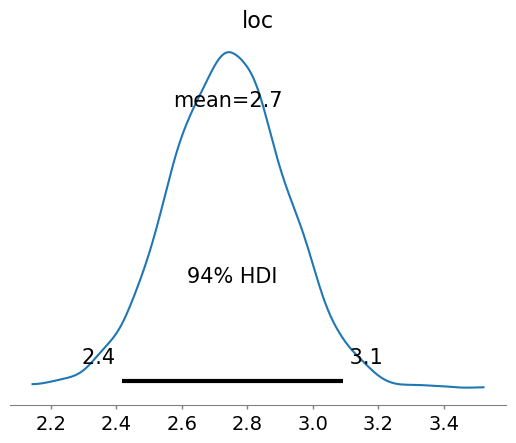

In [4]:
az.plot_posterior(trace, var_names=['loc']);

A recent addition to PyMC4 is variational inference and supported methods currently are `advi` and `fullrank_advi`. After fitting the model, posterior samples can be obtained from the resulting `approximation` object (representing a mean-field approximation in this case).

In [5]:
help(pm.fit)

Help on function fit in module pymc.variational.inference:

fit(n=10000, method='advi', model=None, random_seed=None, start=None, start_sigma=None, inf_kwargs=None, **kwargs)
    Handy shortcut for using inference methods in functional way
    
    Parameters
    ----------
    n: `int`
        number of iterations
    method: str or :class:`Inference`
        string name is case insensitive in:
    
        -   'advi'  for ADVI
        -   'fullrank_advi'  for FullRankADVI
        -   'svgd'  for Stein Variational Gradient Descent
        -   'asvgd'  for Amortized Stein Variational Gradient Descent
    
    model: :class:`Model`
        PyMC model for inference
    random_seed: None or int
    inf_kwargs: dict
        additional kwargs passed to :class:`Inference`
    start: `dict[str, np.ndarray]` or `StartDict`
        starting point for inference
    start_sigma: `dict[str, np.ndarray]`
        starting standard deviation for inference, only available for method 'advi'
    
    Ot

In [8]:
model = Model(x)
with model:
    fit = pm.fit(n=10000, method='advi')
trace = fit.sample(1000)

Finished [100%]: Average Loss = 51.307


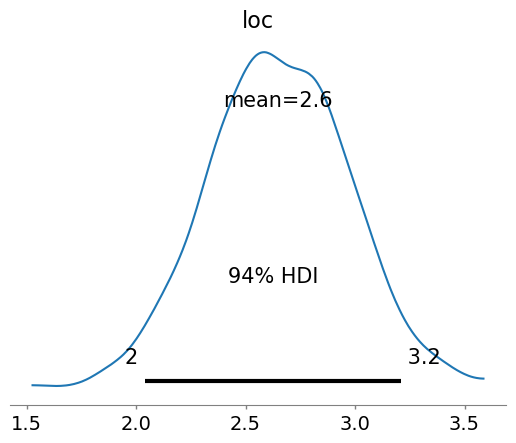

In [9]:
az.plot_posterior(trace, var_names=['loc']);

The history of the variational lower bound  (= negative loss) during training can be displayed with

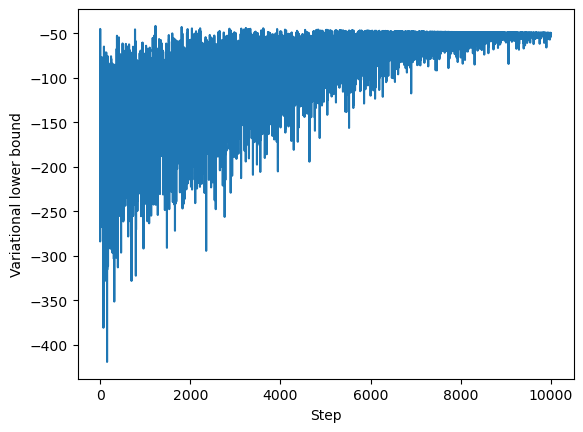

In [14]:
plt.plot(-fit.hist)
plt.ylabel('Variational lower bound')
plt.xlabel('Step');

which confirms a good convergence after about 10,000 steps. Models can also be composed through nesting and used like other PyMC4 random variables.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [loc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


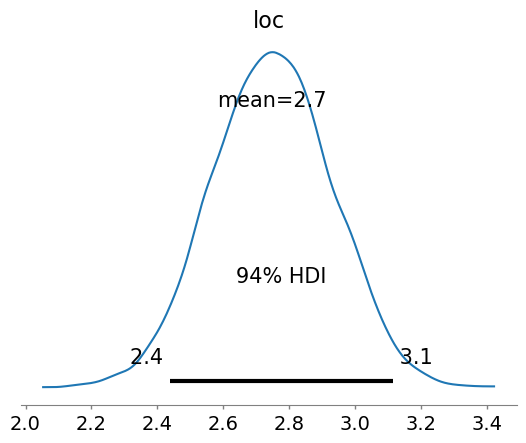

In [30]:

def prior(name, loc=0, scale=10):
    return pm.Normal(name, mu=loc, sigma=scale)
    # with pm.Model() as model:
    #     l = pm.Normal(name, loc=loc, scale=scale)
    # return model


def Model(x):
    with pm.Model() as model:
        loc = prior('loc')
        obs = pm.Normal('obs', mu=loc, sigma=1, observed=x)
    return model

model = Model(x)
with model:
    trace = pm.sample()
az.plot_posterior(trace, var_names=['loc']);    

A more elaborate example is shown below where a neural network is composed of several layers. 

## Example dataset

The dataset used in the following example contains `N` noisy samples from a sinusoidal function `f` in two distinct regions (`x1` and `x2`).

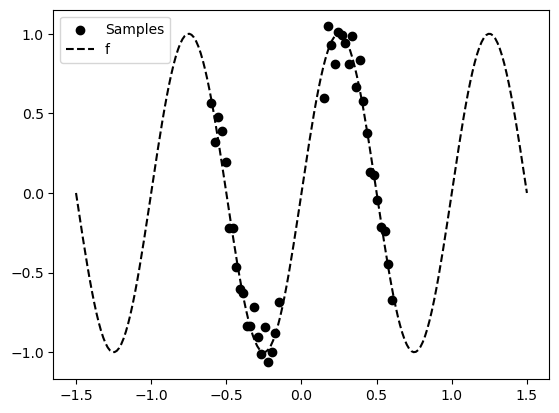

In [31]:
def f(x, noise):
    """Generates noisy samples from a sinusoidal function at x."""
    return np.sin(2 * np.pi * x) + np.random.randn(*x.shape) * noise

N = 40
noise = 0.1

x1 = np.linspace(-0.6, -0.15, N // 2, dtype=np.float32)
x2 = np.linspace(0.15, 0.6, N // 2, dtype=np.float32)

x = np.concatenate([x1, x2]).reshape(-1, 1)
y = f(x, noise=noise)

x_test = np.linspace(-1.5, 1.5, 200, dtype=np.float32).reshape(-1, 1)
f_test = f(x_test, noise=0.0)

plt.scatter(x, y, marker='o', c='k', label='Samples')
plt.plot(x_test, f_test, 'k--', label='f')
plt.legend();

## Bayesian neural network

### Model definition

To model the non-linear relationship between `x` and `y` in the dataset we use a ReLU neural network with two hidden layers, 5 neurons each. The weights of the neural network are random variables instead of deterministic variables. This is what makes a neural network a Bayesian neural network. Here, we assume that the weights are independent random variables. 

The neural network defines a prior over the mean `loc` of the data likelihood `obs` which is represented by a normal distribution. For simplicity, the aleatoric uncertainty (`noise`) in the data is assumed to be known. Thanks to PyMC4's model composition support, priors can be defined layer-wise using the `layer` generator function and composed to a neural network as shown in function `model`. During inference, a posterior distribution over the neural network weights is obtained. 

In [38]:
# @pm.model
def layer(name, x, n_in, n_out, prior_scale, activation=tf.identity):
    # with pm.Model() as model:
    w = pm.Normal(name=f'{name}_w', mu=0, sigma=prior_scale, shape=(n_in, n_out))
    b = pm.Normal(name=f'{name}_b', mu=0, sigma=prior_scale, shape=(1, n_out))
    # print(f'w: {w.shape}, b: {b.shape}')
    # print(x.shape)
    # return activation(pm.math.dot(w, x.T) + b)
    return activation(tf.tensordot(x, w, axes=[1, 0]) + b)

def Model(x, y, prior_scale=1.0):
    with pm.Model() as model:    
        o1 = layer('l1', x, n_in=1, n_out=5, prior_scale=prior_scale, activation=tf.nn.relu)
        o2 = layer('l2', o1, n_in=5, n_out=5, prior_scale=prior_scale, activation=tf.nn.relu)
        o3 = layer('l3', o2, n_in=5, n_out=1, prior_scale=prior_scale)
        pm.Normal(name='obs', loc=o3, scale=noise, observed=y)
    return model


The `batch_stack` parameter of random variable constructors is used to define the shape of the random variable.

### Inference

Tensorflow will automatically run inference on a GPU if available. With the current version of PyMC4, MCMC inference using NUTS on a GPU is quite slow compared to a multi-core CPU (need to investigate that in more detail). To enforce inference on a CPU set environment variable `CUDA_VISIBLE_DEVICES` to an empty value. There is no progress bar visible yet during sampling but the following shouldn't take longer than a few minutes on a modern multi-core CPU.

In [39]:
# MCMC inference with NUTS
model = Model(x, y, prior_scale=3)
with model:
    trace = pm.sample(tune=100, draws=1000)

2023-08-20 00:27:41.843114: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-08-20 00:27:41.843140: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-08-20 00:27:41.843146: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-08-20 00:27:41.843181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-20 00:27:41.843200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ValueError: TypeError: object of type 'TensorVariable' has no len()


Variational inference is significantly faster but the results are less convincing than the MCMC results. I need to investigate that further to see if I'm doing something wrong or if this is an issue with the current PyMC4 development snapshot. We'll therefore use the MCMC results in the following section. If you want to see the VI results, run the following cell instead of the previous one.

In [ ]:
# Variational inference with full rank ADVI
fit = pm.fit(model(x, y, prior_scale=0.5), num_steps=150000, method='fullrank_advi')

# Draw samples from the resulting mean-field approximation
trace = fit.approximation.sample(1000)

The full `trace` can be visualized with `az.plot_trace(trace)`. Here, we only display the posterior over the last layer weights (without bias).

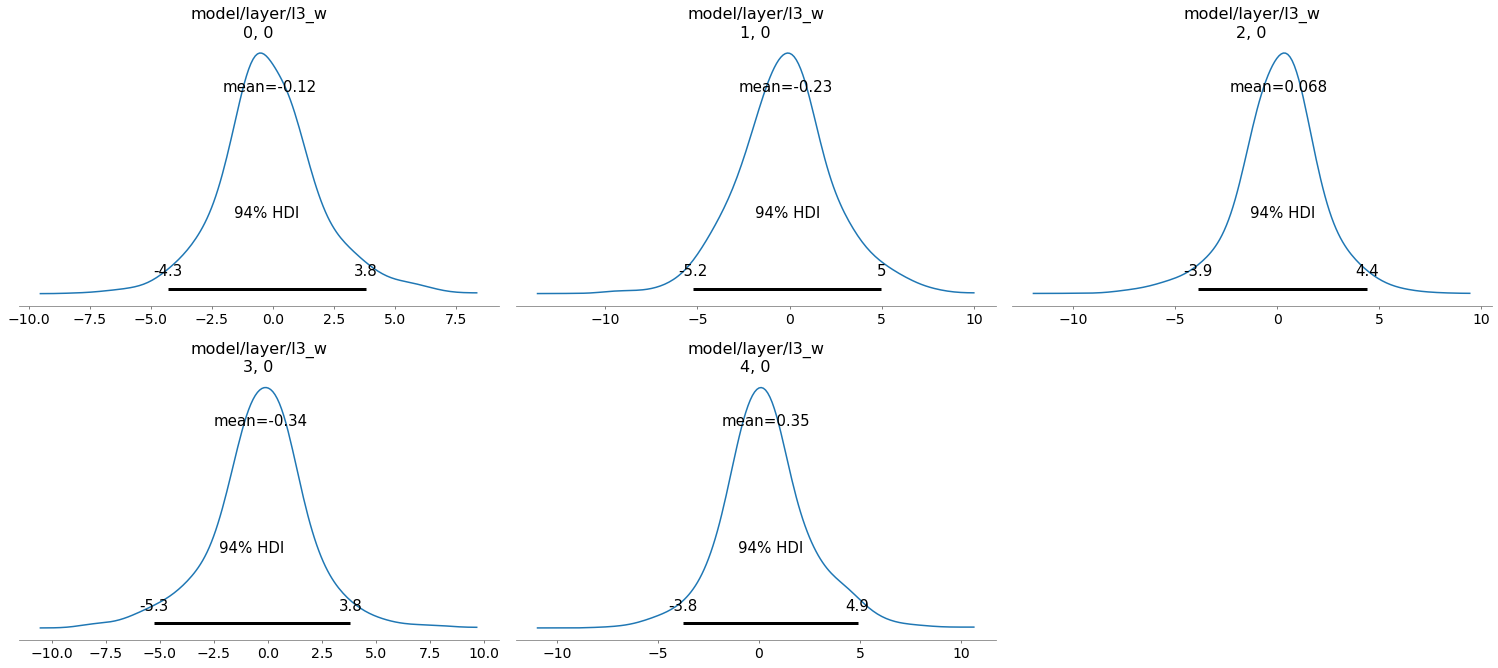

In [21]:
az.plot_posterior(trace, var_names="model/layer/l3_w");

### Prediction

To obtain posterior predictive samples for a test set `x_test` we simply call the `model` generator function again with the test set as argument. This is a nice improvement over PyMC3 which required to setup a shared Theano variable for setting test set values. Target values are ignored during predictive sampling, only the shape of the target array `y` matters, hence we set it to an array of zeros with the same shape as `x_test`.

In [22]:
draws_posterior = pm.sample_posterior_predictive(model(x=x_test, y=np.zeros_like(x_test)), trace, inplace=False)
draws_posterior.posterior_predictive

<xarray.Dataset>
Dimensions:          (chain: 10, draw: 1000, model/obs_dim_0: 200, model/obs_dim_1: 1)
Coordinates:
  * chain            (chain) int64 0 1 2 3 4 5 6 7 8 9
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * model/obs_dim_0  (model/obs_dim_0) int64 0 1 2 3 4 5 ... 195 196 197 198 199
  * model/obs_dim_1  (model/obs_dim_1) int64 0
Data variables:
    model/obs        (chain, draw, model/obs_dim_0, model/obs_dim_1) float32 ...
Attributes:
    created_at:     2020-08-19T12:12:02.008383
    arviz_version:  0.9.0

The predictive mean and standard deviation can be obtained by averaging over chains (axis `0`) and predictive samples (axis `1`) for each of the 200 data points in `x_test` (axis `2`).

In [23]:
predictive_samples = draws_posterior.posterior_predictive.data_vars['model/obs'].values

m = np.mean(predictive_samples, axis=(0, 1)).flatten()
s = np.std(predictive_samples, axis=(0, 1)).flatten()

These statistics can be used to plot model predictions and their variances (together with function `f` and the noisy training data). One can clearly see a higher predictive variance (= higher uncertainty) in regions outside the training data.

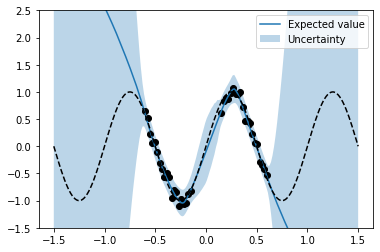

In [24]:
plt.plot(x_test, m, label='Expected value');
plt.fill_between(x_test.flatten(), m + 2 * s, m - 2 * s, alpha = 0.3, label='Uncertainty')

plt.scatter(x, y, marker='o', c='k')
plt.plot(x_test, f_test, 'k--')

plt.ylim(-1.5, 2.5)
plt.legend();

If you think something can be improved in this article (and I'm sure it can) or if I missed other important aspects of PyMC4 please let me know.